<a href="https://colab.research.google.com/github/LukeHackett12/MODRL/blob/main/tensorflowMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install piglet
!pip install pygame
!pip install gym --upgrade
!pip install pyvirtualdisplay

!apt-get install python-opengl -y
!apt install xvfb -y

     |████████████████████████████████| 11.8MB 10.1MB/s 
Requirement already up-to-date: gym in /usr/local/lib/python3.7/dist-packages (0.18.0)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [ ]:
!git clone https://github.com/LukeHackett12/MODRL.git

Cloning into 'MODRL'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 82 (delta 36), reused 64 (delta 21), pack-reused 0
Unpacking objects: 100% (82/82), done.


In [55]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from MODRL.custom_envs.mountain_car.engine import MountainCar

import tensorflow as tf
from tensorflow import keras, Tensor
from keras import backend as K
K.set_image_data_format('channels_last')

import torch
from torchvision import transforms as T
from PIL import Image

import enum
import random
from collections import namedtuple, deque
from typing import NamedTuple

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#################  RESET GAME  ##################
Episode terminated after: 295 (s)
Total score: -1
#################################################
None


In [ ]:

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


class Transition(NamedTuple):
    currStates: Tensor
    actions: Tensor
    rewards: Tensor
    nextStates: Tensor
    dones: Tensor

class DQN():
    def __init__(self, n_input, n_output, learningRate):
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Conv2D(32, input_shape=np.array(n_input), kernel_size=8, strides=4, activation='relu'))
        self.model.add(keras.layers.Conv2D(32, kernel_size=4, strides=2, activation='relu'))
        self.model.add(keras.layers.Conv2D(64, kernel_size=3, strides=1, activation='relu'))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(512,activation='relu'))
        self.model.add(keras.layers.Dense(n_output,activation='linear'))
        self.model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learningRate))

class DQNAgent:
    def __init__(self, stateShape, actionSpace, numPicks, memorySize):
        self.numPicks = numPicks
        self.memorySize = memorySize
        self.replayMemory = deque(maxlen=memorySize)
        self.stateShape = stateShape
        self.actionSpace = actionSpace

        self.step = 0
        self.sync = 1000

        self.alpha = 0.001
        self.epsilon = 1
        self.epsilon_decay = 0.01
        self.epsilon_min=0.01
        self.eps_threshold = 0

        self.gamma = 0.99
        self.tau = 0.01

        self.trainNetwork = DQN(stateShape, len(actionSpace), self.alpha)
        self.targetNetwork = DQN(stateShape, len(actionSpace), self.alpha)
        self.targetNetwork.model.set_weights(self.trainNetwork.model.get_weights())

    def trainDQN(self):
        if len(self.replayMemory) <= self.numPicks:
            return 0
        
        samples = random.sample(self.replayMemory, self.numPicks)
        batch = Transition(*zip(*samples))
        currStates,actions,rewards,nextStates,dones = batch

        currStates = np.squeeze(np.array(currStates), 1)
        Q_currents = self.trainNetwork.model.predict(currStates)

        nextStates = np.squeeze(np.array(nextStates), 1)
        Q_futures = self.targetNetwork.model.predict(nextStates).max(axis = 1)

        rewards = np.array(rewards).reshape(self.numPicks,).astype(float)
        actions = np.array(actions).reshape(self.numPicks,).astype(int)

        dones = np.array(dones).astype(bool)
        notDones = (~dones).astype(float)
        dones = dones.astype(float)

        Q_currents[np.arange(self.numPicks), actions] = rewards*dones + (rewards + Q_futures * self.gamma)*notDones

        hist = self.trainNetwork.model.fit(tf.convert_to_tensor(currStates), tf.convert_to_tensor(Q_currents), epochs=1, verbose=0)  
        return hist.history['loss'][0]

    def selectAction(self, state):
      self.step += 1
      self.epsilon = max(self.epsilon, self.epsilon_min)

      q = -100000
      if np.random.rand(1) < self.epsilon:
          action = np.random.randint(0, 3)
      else:
          preds = np.squeeze(self.trainNetwork.model(state, training=False).numpy(), axis=0)
          action = np.argmax(preds)
          q = preds[action]
      return action,q

    def addMemory(self, memory):
        self.replayMemory.append(memory)

    def save(self):
        save_path = (
            f"./mountain_car_{int(self.step)}.chkpt"
        )
        agent.trainNetwork.model.save(
            save_path
        )
        print(f"MountainNet saved to {save_path} done!")


In [ ]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize((40,40), interpolation=Image.CUBIC),
                    T.ToTensor()])

def process_screen(observation):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = observation
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).numpy().transpose((2,1,0))

In [ ]:
env = MountainCar(speed=1e8, graphical_state=True, render=True, is_debug=True)
agent = DQNAgent(stateShape=(40, 40, 3),
                   actionSpace=env.get_action_space(), numPicks=32, memorySize=10000)


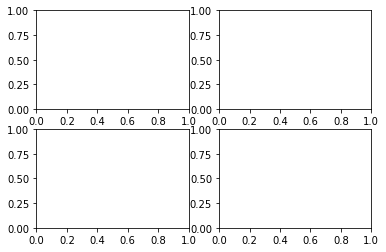

#################  RESET GAME  ##################
Episode terminated after: 330 (s)
Total score: -1
#################################################


ValueError: ignored

In [56]:

episode_score = []
episode_qs = []
episode_height = []
episode_loss = []
episode_decay = []

fig, ax = plt.subplots(2, 2)
fig.canvas.draw()
plt.show(block=False)


def plot_episode():
    ax[0][0].title.set_text('Training Score')
    ax[0][0].set_xlabel('Episode')
    ax[0][0].set_ylabel('Score')
    ax[0][0].plot(episode_score, 'b')

    ax[0][1].title.set_text('Training Height')
    ax[0][1].set_xlabel('Episode')
    ax[0][1].set_ylabel('Height')
    ax[0][1].plot(episode_height, 'g')

    ax[1][0].title.set_text('Training Loss')
    ax[1][0].set_xlabel('Episode')
    ax[1][0].set_ylabel('Loss')
    ax[1][0].plot(episode_loss, 'r')

    ax[1][1].title.set_text('Training Q Vals')
    ax[1][1].set_xlabel('Episode')
    ax[1][1].set_ylabel('Qs')
    ax[1][1].plot(episode_qs, 'c')
    fig.canvas.draw()
    plt.show(block=False)
    plt.pause(.001)

def episode():
    done = False
    rewardsSum = 0
    qSum = 0
    qActions = 1
    lossSum = 0

    currState = process_screen(env.reset())
    lastState = currState
    state = currState - lastState
    state = tf.expand_dims(tf.constant(state), 0)

    maxHeight = -10000

    while not done:
        action, q = agent.selectAction(state)
        if q != -100000:
            qSum += q
            qActions += 1

        obs, reward, done, info = env.step_all(action)

        reward = reward[0]

        maxHeight = max(info[0], maxHeight)
        if info[0] >= 0.5:
            reward += 10

        lastState = currState
        currState = process_screen(obs)

        nextState = currState - lastState
        nextState = tf.expand_dims(tf.constant(nextState), 0)
        rewardsSum = np.add(rewardsSum, reward)

        loss = agent.trainDQN()
        agent.addMemory((state, action, reward, nextState, done))
        state = nextState
        lossSum += loss

    episode_score.append(rewardsSum)
    episode_qs.append(qSum/qActions)
    episode_height.append(maxHeight)
    episode_loss.append(lossSum)
    episode_decay.append(agent.epsilon)
    plot_episode()

    agent.epsilon -= agent.epsilon_decay

    if ep % agent.sync == 0:
      agent.targetNetwork.model.set_weights(agent.trainNetwork.model.get_weights())

    if rewardsSum != -202:
        agent.save()

    print("now epsilon is {}, the reward is {} with loss {} in episode {}".format(agent.epsilon, rewardsSum, lossSum, ep)) 

ep = 1
while ep < 10000:
    episode()
    ep += 1

env.close()